In [22]:
%matplotlib inline

In [23]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import poisson

In [25]:
# Global variables

# Time horizon
# TIME_HORIZON = 1000

# Queue size
MAX_QUEUE_SIZE = 20

# Arrival average of customers per unit time (Poisson process)
ARRIVAL_SIMPLE = 8
ARRIVAL_COMPLEX = 5

# Service rate of agents for each query types (Exponential distribution)
## Agent 1
SERVICE_SIMPLE_1 = 8
SERVICE_COMPLEX_1 = 3
## Agent 2
SERVICE_SIMPLE_2 = 6
SERVICE_COMPLEX_2 = 5

# Discount factor for future rewards
DISCOUNT = 0.95

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)
# State space size
# STATE_SIZE = np.prod(STATE_SPACE)

# Call type: 0 = simple, 1 = complex
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [0, 1]

In [26]:
# Upper bound for poisson distribution
# Because the poisson distribution may produce a very large number of customers, which is not realistic
POISSON_UPPER_BOUND = 15

# Probability for poisson distribution
poisson_cache = dict()

def poisson_probability(n, lam):
    global poisson_cache
    key = (n, lam)
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

In [27]:
def queue_proportions(q1, q2):
    """
    Calculate the proportions of simple and complex calls in the queues.
    """    
    # Assumption: probability of simple and complex calls assigned to agents depends on their service rates
    prob_simple_1 = SERVICE_SIMPLE_1 / (SERVICE_SIMPLE_1 + SERVICE_COMPLEX_1)
    prob_complex_1 = SERVICE_COMPLEX_1 / (SERVICE_SIMPLE_1 + SERVICE_COMPLEX_1)
    prob_simple_2 = 1 - prob_simple_1
    prob_complex_2 = 1 - prob_complex_1
    
    # Then the arrival rate of each call types to the queues is
    lam_1_simple = ARRIVAL_SIMPLE * prob_simple_1
    lam_1_complex = ARRIVAL_COMPLEX * prob_complex_1
    lam_2_simple = ARRIVAL_SIMPLE * prob_simple_2
    lam_2_complex = ARRIVAL_COMPLEX * prob_complex_2
    
    # Proportions of simple and complex calls in queue 1
    prop1_simple = q1 * lam_1_simple / (q1 * lam_1_simple + q1 * lam_1_complex) if q1 > 0 else 0.5
    prop1_complex = 1 - prop1_simple
    
    # Proportions of simple and complex calls in queue 2
    prop2_simple = q2 * lam_2_simple / (q2 * lam_2_simple + q2 * lam_2_complex) if q2 > 0 else 0.5
    prop2_complex = 1 - prop2_simple
    
    return prop1_simple, prop1_complex, prop2_simple, prop2_complex

def effective_mu(prop1_simple, prop1_complex, prop2_simple, prop2_complex):
    """
    Effective service rate of the agent given the composition of the queue.
    """
    # Effective service rate for queue 1
    mu_1_eff = 1 / (prop1_simple / SERVICE_SIMPLE_1 + prop1_complex / SERVICE_COMPLEX_1)
    # Effective service rate for queue 2
    mu_2_eff = 1 / (prop2_simple / SERVICE_SIMPLE_2 + prop2_complex / SERVICE_COMPLEX_2)
    
    return mu_1_eff, mu_2_eff

def expected_waiting_time(state, action, mu_1_eff, mu_2_eff):
    """
    Expected waiting times given the state and effective service rates.
    The state is a tuple (queue 1 size, queue 2 size, call type).
    """
    q1, q2, call_type = state
    
    wait = 0.0
    
    if action == 0:
        # Route to queue 1
        if call_type == 0:
            # Simple call
            wait = q1 / mu_1_eff + 1 / SERVICE_SIMPLE_1
        else:
            # Complex call
            wait = q1 / mu_1_eff + 1 / SERVICE_COMPLEX_1
    else:
        # Route to queue 2
        if call_type == 0:
            # Simple call
            wait = q2 / mu_2_eff + 1 / SERVICE_SIMPLE_2
        else:
            # Complex call
            wait = q2 / mu_2_eff + 1 / SERVICE_COMPLEX_2
            
    return -wait # Negative because we want to minimise waiting time

In [28]:
def policy_evaluation(policy_simple, policy_complex, value, threshold=1e-4):
    """
    Evaluate the policy by calculating state values
    """
    while True:
        delta = 0
        # For each state
        for q1 in range(MAX_QUEUE_SIZE + 1):
            for q2 in range(MAX_QUEUE_SIZE + 1):
                for call_type in CALL_TYPE:
                    old_value = value[(q1, q2, call_type)]
                    
                    # Get action from policy
                    if call_type == 0:
                        action = policy_simple[q1, q2]
                    else:
                        action = policy_complex[q1, q2]
                        
                    # Calculate the new value
                    prop1_simple, prop1_complex, prop2_simple, prop2_complex = queue_proportions(q1, q2)
                    mu_1_eff, mu_2_eff = effective_mu(prop1_simple, prop1_complex, prop2_simple, prop2_complex)
                    waiting_cost = expected_waiting_time((q1, q2, call_type), action, mu_1_eff, mu_2_eff)
                    
                    # Calculate expected next state value
                    expected_next_cost = 0.0
                    
                    next_q1 = q1
                    next_q2 = q2
                    
                    if action == 0 and q1 < MAX_QUEUE_SIZE:
                        next_q1 += 1
                    elif action == 1 and q2 < MAX_QUEUE_SIZE:
                        next_q2 += 1
                        
                    prob_simple = poisson_probability(1, ARRIVAL_SIMPLE/(ARRIVAL_SIMPLE + ARRIVAL_COMPLEX))
                    prob_complex = poisson_probability(1, ARRIVAL_COMPLEX/(ARRIVAL_SIMPLE + ARRIVAL_COMPLEX))
                    
                    # Expected value of the next state
                    expected_next_cost = prob_simple * value[(min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 0)] + \
                        prob_complex * value[(min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 1)]
                        
                    # Update value function
                    value[(q1, q2, call_type)] = waiting_cost + DISCOUNT * expected_next_cost
                    
                    # Track the maximum change in value
                    delta = max(delta, abs(old_value - value[(q1, q2, call_type)]))
        
        # Check for convergence
        if delta < threshold:
            break
    
    return value
                    
                    
def policy_improvement(value):
    """
    Improve policy based on current value function
    """
    policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
    policy_complex = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
    
    # For each state
    for q1 in range(MAX_QUEUE_SIZE + 1):
        for q2 in range(MAX_QUEUE_SIZE + 1):
            # For simple calls
            action_values = []
            for action in ACTIONS:
                
                # Calculate the expected proportions of simple and complex calls in the queues
                prop1_simple, prop1_complex, prop2_simple, prop2_complex = queue_proportions(q1, q2)
                
                # Calculate effective service rates
                mu_1_eff, mu_2_eff = effective_mu(prop1_simple, prop1_complex, prop2_simple, prop2_complex)
                
                # Calculate expected waiting times
                waiting_cost = expected_waiting_time((q1, q2, 0), action, mu_1_eff, mu_2_eff)
                
                # Calculate next state based on action
                next_q1 = q1
                next_q2 = q2
                
                if action == 0 and q1 < MAX_QUEUE_SIZE:
                    next_q1 += 1
                elif action == 1 and q2 < MAX_QUEUE_SIZE:
                    next_q2 += 1
                    
                # Expected value of the next state
                prob_simple = poisson_probability(1, ARRIVAL_SIMPLE/(ARRIVAL_SIMPLE + ARRIVAL_COMPLEX))
                prob_complex = poisson_probability(1, ARRIVAL_COMPLEX/(ARRIVAL_SIMPLE + ARRIVAL_COMPLEX))
                
                expected_next_cost = prob_simple * value[(min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 0)] + \
                    prob_complex * value[(min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 1)]
                    
                action_values.append(waiting_cost + DISCOUNT * expected_next_cost)
            
            # Choose the action with the minimum expected waiting time
            policy_simple[q1, q2] = ACTIONS[np.argmax(action_values)]
                
            # For complex calls
            action_values = []
            for action in ACTIONS:
                
                # Calculate the expected proportions of simple and complex calls in the queues
                prop1_simple, prop1_complex, prop2_simple, prop2_complex = queue_proportions(q1, q2)
                
                # Calculate effective service rates
                mu_1_eff, mu_2_eff = effective_mu(prop1_simple, prop1_complex, prop2_simple, prop2_complex)
                
                # Calculate expected waiting times
                waiting_cost = expected_waiting_time((q1, q2, 1), action, mu_1_eff, mu_2_eff)
                
                # Calculate next state based on action
                next_q1 = q1
                next_q2 = q2
                
                if action == 0 and q1 < MAX_QUEUE_SIZE:
                    next_q1 += 1
                elif action == 1 and q2 < MAX_QUEUE_SIZE:
                    next_q2 += 1
                    
                # Expected value of the next state
                prob_simple = poisson_probability(1, ARRIVAL_SIMPLE/(ARRIVAL_SIMPLE + ARRIVAL_COMPLEX))
                prob_complex = poisson_probability(1, ARRIVAL_COMPLEX/(ARRIVAL_SIMPLE + ARRIVAL_COMPLEX))
                
                expected_next_cost = prob_simple * value[(min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 0)] + \
                    prob_complex * value[(min(next_q1, MAX_QUEUE_SIZE), min(next_q2, MAX_QUEUE_SIZE), 1)]
                    
                action_values.append(waiting_cost + DISCOUNT * expected_next_cost)
            
            # Choose the action with the minimum expected waiting time
            policy_complex[q1, q2] = ACTIONS[np.argmax(action_values)]
    
    return policy_simple, policy_complex
                

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Policies have converged


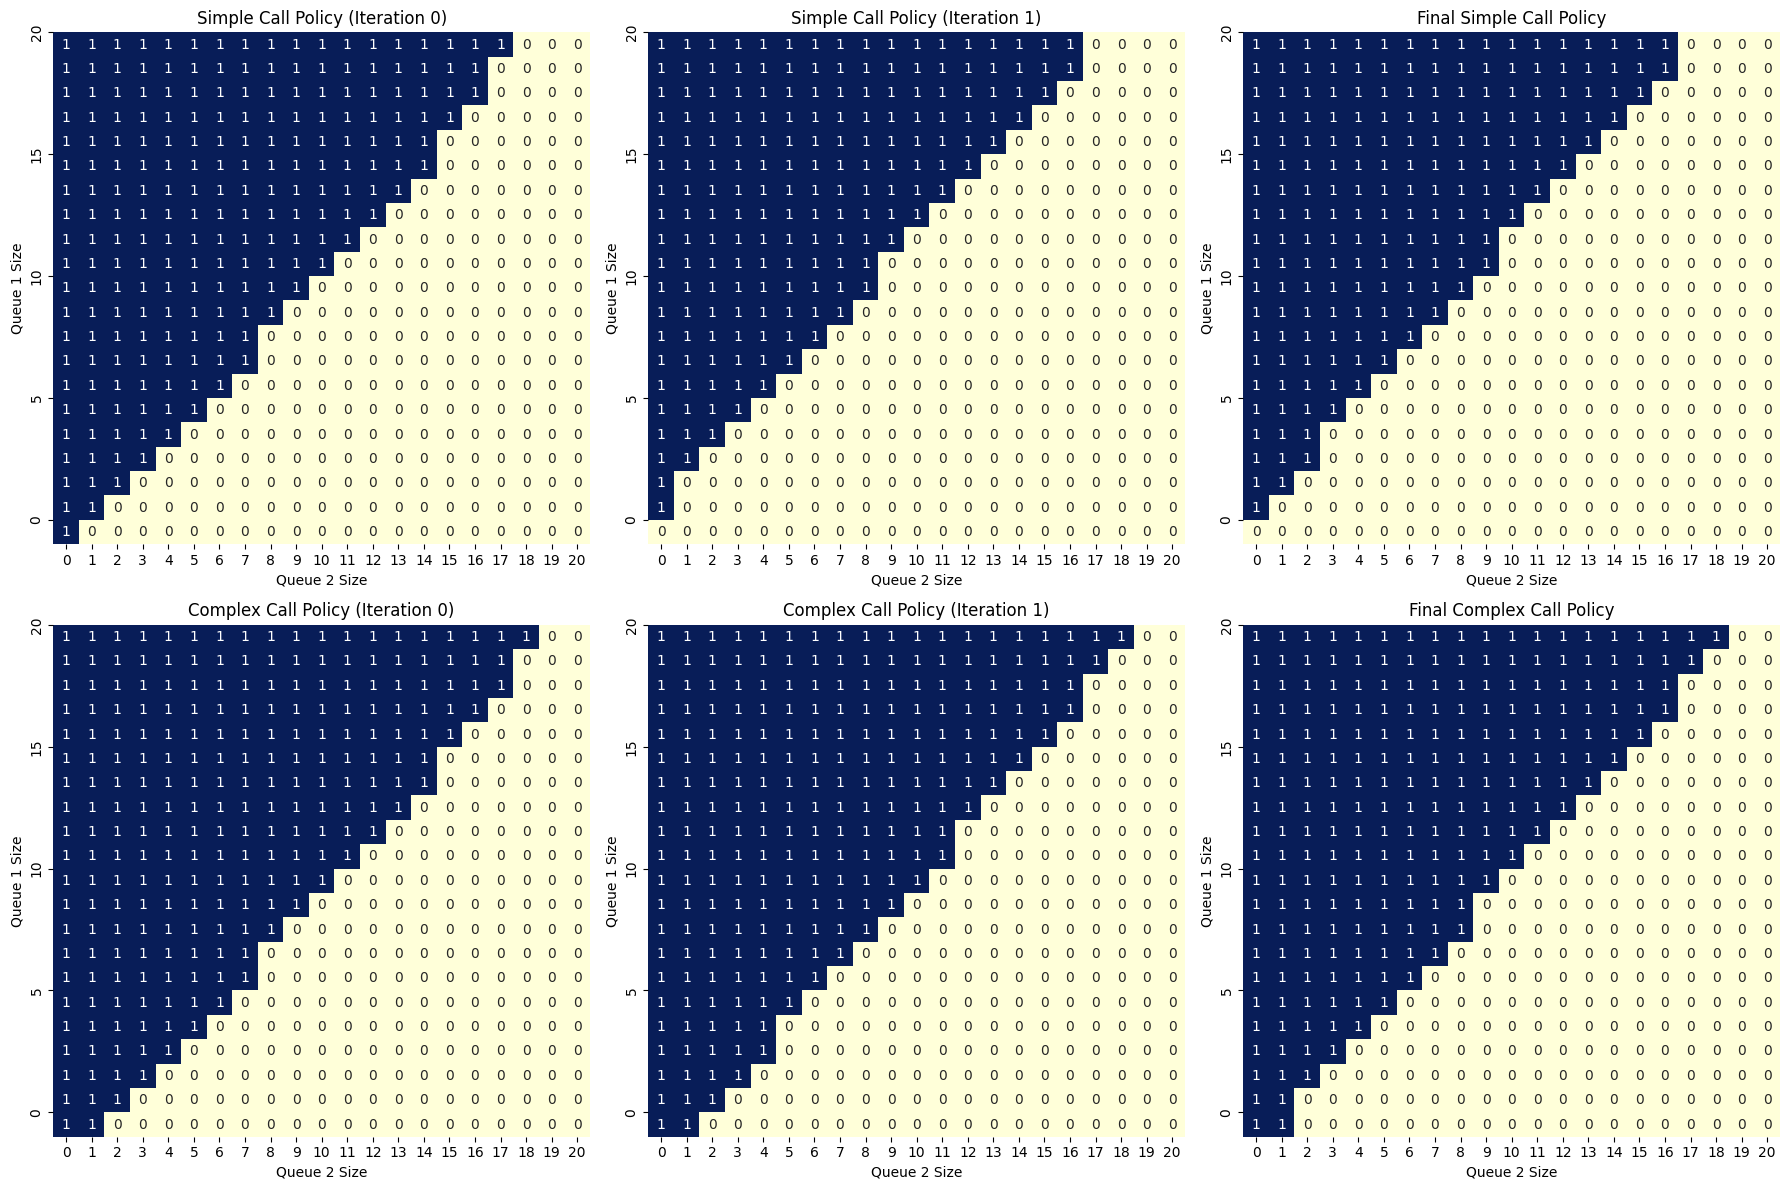

In [36]:
# Run policy iteration algorithm

# Initialise policies
policy_simple = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
policy_complex = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)

# Initialise value function
value = np.zeros(STATE_SPACE)

# For visualisation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
iteration = 0
max_iterations = 5

while iteration < max_iterations:
    print(f"Iteration {iteration}")
    
    # Policy iteration
    # Policy evaluation
    value = policy_evaluation(policy_simple, policy_complex, value)
    
    # Policy improvement
    new_policy_simple, new_policy_complex = policy_improvement(value)
    
    # Check if policies have changed
    if np.array_equal(policy_simple, new_policy_simple) and np.array_equal(policy_complex, new_policy_complex):
        print("Policies have converged")
        policy_simple, policy_complex = new_policy_simple, new_policy_complex
        break
    
    policy_simple, policy_complex = new_policy_simple, new_policy_complex
    
    # Visualise current policies
    if iteration < 2:
        # Simple call policy
        sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0, iteration], annot=np.flipud(policy_simple),
                    cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
        axes[0, iteration].set_title(f'Simple Call Policy (Iteration {iteration})')
        axes[0, iteration].set_ylabel('Queue 1 Size')
        axes[0, iteration].set_xlabel('Queue 2 Size')
        axes[0, iteration].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
        axes[0, iteration].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))
        
        # Complex call policy
        sns.heatmap(np.flipud(policy_complex), cmap="YlGnBu", ax=axes[1, iteration], annot=np.flipud(policy_complex),
                    cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
        axes[1, iteration].set_title(f'Complex Call Policy (Iteration {iteration})')
        axes[1, iteration].set_ylabel('Queue 1 Size')
        axes[1, iteration].set_xlabel('Queue 2 Size')
        axes[1, iteration].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
        axes[1, iteration].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))
    
    iteration += 1
    
# Final policies visualisation
# Simple call policy
sns.heatmap(np.flipud(policy_simple), cmap="YlGnBu", ax=axes[0, 2], annot=np.flipud(policy_simple),
            cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
axes[0, 2].set_title('Final Simple Call Policy')
axes[0, 2].set_ylabel('Queue 1 Size')
axes[0, 2].set_xlabel('Queue 2 Size')
axes[0, 2].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[0, 2].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

# Complex call policy
sns.heatmap(np.flipud(policy_complex), cmap="YlGnBu", ax=axes[1, 2], annot=np.flipud(policy_complex),
            cbar=False, cbar_kws={'label': 'Action (0=Queue 1, 1=Queue 2)'})
axes[1, 2].set_title('Final Complex Call Policy')
axes[1, 2].set_ylabel('Queue 1 Size')
axes[1, 2].set_xlabel('Queue 2 Size')
axes[1, 2].set_yticks(list(reversed(range(0, MAX_QUEUE_SIZE + 1, 5))))
axes[1, 2].set_yticklabels(range(0, MAX_QUEUE_SIZE + 1, 5))

plt.tight_layout()
plt.show()

### What to implement next:

* Save policies into pickles
* Simulation using the optimal policies
* Comparison between optimal policies with another policies